In [1]:
from bmcs_shell.api import FETriangularMesh, TriXDomainFE
import numpy as np

In [2]:
wb_mesh_0 = FETriangularMesh(
    X_Id = [[1.5,2,0], [7,3.5,0], [4,7,0]],
#    X_Id = [[-1,0,0], [1,0,0], [0,1,0]],
#    X_Id = [[0,0,0], [1,0,0], [0,1,0]],
    I_Fi = [[0,1,2]],
)
fixed_dofs_0 = [0,1,2,4,5,6,8]
loaded_dofs_0 = [3,7]

wb_mesh_1 = FETriangularMesh(
    X_Id = [[0,-1,1], [0,1,1], [-2,0,0], [2,0,0]],
    I_Fi = [[0,1,2], [0,3,1]],
)
fixed_dofs_1 = [2,5,6,7,8,10,11]
loaded_dofs_1 = [9]

wb_mesh_2 = FETriangularMesh(
    X_Id = [[0,0,0], [2,0,0], [2,2,0], [2,0,0], [1,1,0]],
    I_Fi = [[0,1,4], [1,2,4], [2,3,4], [3,0,4]],
)

fixed_dofs_2 = [0,1,2,5,8,9,10,11,14]
loaded_dofs_2 = [3,6]

wb_mesh_3 = FETriangularMesh(
    X_Id = [[0,-1,1], [0,1,1], [2,0,0], [-2,0,0]],
    I_Fi = [[0,2,1], [0,3,1]],
)

fixed_dofs_3 = [1,4,6,7,8,9,10,11]
loaded_dofs_3 = [2,5]

wb_mesh = wb_mesh_0
fixed_dofs = fixed_dofs_0
loaded_dofs_0 = loaded_dofs_0

# WBDomain operators

In [3]:
xdomain = WBXDomainFE(
    mesh=wb_mesh
)

In [4]:
xdomain.x_Eia

array([[[0.        , 0.        ],
        [5.70087713, 0.        ],
        [3.72749658, 4.16602559]]])

In [5]:
xdomain.F_N

array([[0, 1, 2]])

In [6]:
xdomain.J_Emar

array([[[[-3.72749658,  1.97338054],
         [-4.16602559, -4.16602559]]]])

In [7]:
xdomain.det_J_Em


array([[23.75]])

In [8]:
xdomain.F_area

array([11.875])

# Kinematic mapping


\begin{align}
 u_a = L_i u_{ia}
\end{align}
\begin{align}
\varepsilon_{ab} &= \frac{1}{2}
\left(\frac{\partial u_a}{\partial x_b} +
 \frac{\partial u_b}{\partial x_a}\right) \\
&= \frac{1}{2}
\left( \delta_{ac} \delta_{bd} + \delta_{ad} \delta_{bc}\right)
 \frac{\partial u_c}{\partial x_d}
\\
&=
 \frac{1}{2}
\left( \delta_{ac} \delta_{bd} + \delta_{ad} \delta_{bc}\right)
 \frac{\partial L_i}{\partial x_d} u_{ic}
\\
 &=
 \frac{1}{2}
\left( \delta_{ac} \delta_{bd} + \delta_{ad} \delta_{bc}\right)
\frac{\partial L_i}{\partial \eta_j} \frac{\partial \eta_j}{\partial x_d} u_{ic}
\end{align}

\begin{align}
L_1 &= \eta_1, L_2 = \eta_2, L_3 = 1 - \eta_1 - \eta_2 \\
\frac{\partial L_i}{\partial \eta_j} & =
\left[
\begin{array}{rr}
1 & 0 \\ 0 & 1 \\ -1 &-1
\end{array}
\right]
\end{align}

\begin{align}
x_{a} = L_i x_{ia}
\end{align}
\begin{align}
\frac{\partial x_a}{\partial \eta_j}
& = \frac{\partial L_i}{\partial \eta_j} x_{ia}
\end{align}
\begin{align}
\end{align}



In [9]:
x_Ia = xdomain.X_Id[...,:-1]
x_Eia = x_Ia[xdomain.I_Ei]
delta = np.identity(2)
Diff1_abcd = 0.5 * (
    np.einsum('ac,bd->abcd', delta, delta) +
    np.einsum('ad,bc->abcd', delta, delta)
)
dN_mir = np.array([[[1,0],[0,1],[-1,-1]]], dtype=np.float_)
J_Emar = np.einsum('mir,Eia->Emar', dN_mir, x_Eia)
inv_J_Emra = np.linalg.inv(J_Emar)
det_J_Emra = np.linalg.det(J_Emar)
B_Eimabc = np.einsum('abcd,mir,Emrd->Eimabc',Diff1_abcd,dN_mir,inv_J_Emra)
U_Eic = np.array([[[0,0],[1,0],[0,1]]], dtype=np.float_)
eps_Emab = np.einsum('Eimabc,Eic->Emab', B_Eimabc, U_Eic)
eps_Emab

array([[[[ 0.21052632, -0.08421053],
         [-0.08421053,  0.23157895]]]])

In [10]:
B2_Eimabc = np.einsum('abcd,imr,Emrd->Eimabc',Diff1_abcd,xdomain.fets.dN_imr,inv_J_Emra)

In [11]:
inv_J_Emra

array([[[[-0.14736842, -0.12631579],
         [ 0.21052632, -0.10526316]]]])

In [12]:
eps2_Emab = np.einsum('Eimabc,Eic->Emab', xdomain.B1_Eimabc, U_Eic)
eps2_Emab



array([[[[ 0.1754116 , -0.07847361],
         [-0.07847361,  0.24003693]]]])

# Verification using standard vectorial CST formulation

In [13]:
E_ = 70e+3
nu_ = 0.3

In [14]:
xdomain.x_Eia

array([[[0.        , 0.        ],
        [5.70087713, 0.        ],
        [3.72749658, 4.16602559]]])

In [15]:
xx_Ei, yy_Ei = np.einsum('...a->a...', xdomain.x_Eia)
xx_Ei, yy_Ei

(array([[0.        , 5.70087713, 3.72749658]]),
 array([[0.        , 0.        , 4.16602559]]))

In [16]:
y23 = yy_Ei[:,1] - yy_Ei[:,2]
y31 = yy_Ei[:,2] - yy_Ei[:,0]
y12 = yy_Ei[:,0] - yy_Ei[:,1]
x32 = xx_Ei[:,2] - xx_Ei[:,1]
x13 = xx_Ei[:,0] - xx_Ei[:,2]
x21 = xx_Ei[:,1] - xx_Ei[:,0]
x23 = -x32
y32 = -y23
y13 = -y31

J_Ear = np.array([[x13,y13],[x23,y23]])
J_Ear = np.einsum('ar...->...ar', J_Ear)
J_Ear

array([[[-3.72749658, -4.16602559],
        [ 1.97338054, -4.16602559]]])

In [17]:
inv_J_Ear = np.linalg.inv(J_Ear)
det_J_E = np.linalg.det(J_Ear)
J_Ear, det_J_E

(array([[[-3.72749658, -4.16602559],
         [ 1.97338054, -4.16602559]]]),
 array([23.75]))

In [18]:
X_Eid = xdomain.X_Id[xdomain.I_Ei]
J_Emar = np.einsum('imr,Eia->Emra', xdomain.fets.dN_imr, X_Eid[...,:-1])
#J_Emar, xdomain.det_J_Em, xdomain.J_Emar

In [19]:
O = np.zeros_like(y23)
B_soE = np.array(
    [
        [y23, O, y31, O, y12, O],
        [O, x32, O, x13, O, x21],
        [x32,y23,x13,y31,x21,y12]
    ]
)

B_Eso = np.einsum('soE,E->Eso', B_soE, 1/det_J_E )

In [20]:
B_Eso

array([[[-0.1754116 ,  0.        ,  0.1754116 ,  0.        ,
          0.        ,  0.        ],
        [ 0.        , -0.08308971,  0.        , -0.15694722,
          0.        ,  0.24003693],
        [-0.08308971, -0.1754116 , -0.15694722,  0.1754116 ,
          0.24003693,  0.        ]]])

In [21]:
np.einsum('Eso,Eo->s', B_Eso, U_Eic.reshape(-1,6))

array([ 0.1754116 ,  0.24003693, -0.15694722])

In [22]:
D_st = E_ / (1 - nu_**2) * np.array([[1, nu_, 0], [nu_, 1, 0], [0, 0, 0.5*(1-nu_)]])

In [23]:
k2_ij = np.einsum('Eso,st,Etp,E->Eop', B_Eso, D_st, B_Eso, det_J_E) / 2

In [24]:
k2_ij
k2_ij

array([[[ 30313.76518219,   8653.84615385, -23937.24696356,
           2884.61538462,  -6376.51821862, -11538.46153846],
        [  8653.84615385,  16143.72469636,   4807.69230769,
           2074.89878543, -13461.53846154, -18218.62348178],
        [-23937.24696356,   4807.69230769,  35981.78137652,
         -16346.15384615, -12044.53441296,  11538.46153846],
        [  2884.61538462,   2074.89878543, -16346.15384615,
          32338.05668016,  13461.53846154, -34412.95546559],
        [ -6376.51821862, -13461.53846154, -12044.53441296,
          13461.53846154,  18421.05263158,      0.        ],
        [-11538.46153846, -18218.62348178,  11538.46153846,
         -34412.95546559,      0.        ,  52631.57894737]]])

In [25]:
K_Eiejf = k2_ij.reshape(-1,3,2,3,2)

In [26]:
K_Eiajb = xdomain.xk2K(K_Eiejf)

K_Eiajb.reshape(-1,9,9)

array([[[ 24939.27125506,  11052.63157895,      0.        ,
         -24089.06882591,  -4251.01214575,      0.        ,
           -850.20242915,  -6801.6194332 ,      0.        ],
        [ 11052.63157895,  21518.21862348,      0.        ,
          -2327.93522267,   2226.72064777,      0.        ,
          -8724.69635628, -23744.93927126,      0.        ],
        [     0.        ,      0.        ,      0.        ,
              0.        ,      0.        ,      0.        ,
              0.        ,      0.        ,      0.        ],
        [-24089.06882591,  -2327.93522267,      0.        ,
          44028.34008097, -13157.89473684,      0.        ,
         -19939.27125506,  15485.82995951,      0.        ],
        [ -4251.01214575,   2226.72064777,      0.        ,
         -13157.89473684,  24291.49797571,      0.        ,
          17408.90688259, -26518.21862348,      0.        ],
        [     0.        ,      0.        ,      0.        ,
              0.        ,      0.  

# Patch test

In [27]:
from bmcs_shell.folding.vmats2D_elastic import MATS2DElastic

In [28]:
m = MATS2DElastic()

In [29]:
from ibvpy.bcond import BCDof

In [30]:
u_cntl = 1
fixed_dofs = [0,1,2,5,6,7,8]
loaded_dofs = [3]
# fixed_dofs = [0,1,2,5,8,9,10,11,14]
# loaded_dofs = [3,6]
bc_fixed = [BCDof(var= 'u', dof=dof, value=0 )
           for dof in fixed_dofs]
bc_loaded = [BCDof(var= 'f', dof=dof, value=u_cntl )
           for dof in loaded_dofs]

In [31]:
from ibvpy.sim.tstep_bc import TStepBC
from ibvpy.mats.viz3d_scalar_field import \
    Vis3DStateField, Viz3DScalarField

In [32]:
from ibvpy.mats.viz3d_tensor_field import \
    Vis3DTensorField, Viz3DTensorField

In [33]:
ts = TStepBC(
    domains=[(xdomain, m)],
    bc=bc_fixed + bc_loaded,
)

# m.hist.vis_record = {
#     'strain': Vis3DTensorField(var='eps_ab'),
# #     'stress': Vis3DTensorField(var='sig_ab'),
#    'damage': Vis3DStateField(var='omega_a'),
#     #        'kinematic hardening': Vis3DStateField(var='z_a')
# }

# Transformation global-local test

\begin{align}
u_f &= T_{fb} U_b \\
f_e &= k_{ef} u_f \\
F_a &= T_{ea} f_e
\end{align}
\begin{align}
 F_a = K_{ab} U_b = T_{ea} k_{ef} T_{fb} U_b
\end{align}

In [34]:
ts.fe_domain[0].tmodel

In [35]:
ts.fe_domain[0]

In [36]:
s = ts.sim
s.tloop.k_max = 10
s.tline.step = 0.1
s.tloop.verbose = True
s.run()

t:	 0.00(0), 
	 0.10(1), 
	 0.20(1), 
	 0.30(1), 
	 0.40(1), 
	 0.50(1), 
	 0.60(1), 
	 0.70(1), 
	 0.80(1), 
	 0.90(1), 
	 1.00(1), 



In [37]:
import numpy as np
F_to = ts.hist.F_t
U_to = ts.hist.U_t
F_loaded = np.sum(F_to[:, loaded_dofs], axis=-1)
F_fixed = np.sum(F_to[:, fixed_dofs], axis=-1)
U_loaded = np.average(U_to[:, loaded_dofs], axis=-1)


In [38]:
F_loaded
U_loaded


array([0.00000000e+00, 5.57929412e-06, 1.11585882e-05, 1.67378824e-05,
       2.23171765e-05, 2.78964706e-05, 3.34757647e-05, 3.90550588e-05,
       4.46343529e-05, 5.02136471e-05, 5.57929412e-05])

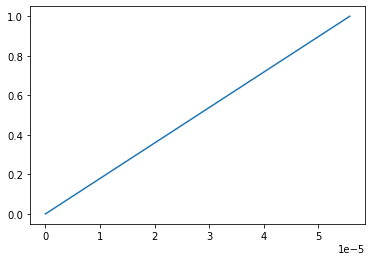

In [39]:
import matplotlib.pylab as plt
plt.plot(U_loaded, F_loaded)




# Uniaxial tension test

In [65]:
wb_mesh = FETriangularMesh(
    X_Id = [[0,0,0], [1000,0,0], [1000,1000,0],[0,1000,0]],
    I_Fi = [[0,1,2], [0,2,3]],
)
fixed_dofs = [0,1,2,4,5,7,8,9,11]
loaded_dofs = [3,6]

In [66]:
xdomain = XWBDomain(
    integ_factor = 1,
    mesh=wb_mesh
)

In [67]:
tmodel = MATS2DElastic(E_=1, nu=00)

In [68]:
u_cntl = 5000
bc_fixed = [BCDof(var= 'u', dof=dof, value=0 )
           for dof in fixed_dofs]
bc_loaded = [BCDof(var= 'f', dof=dof, value=u_cntl )
           for dof in loaded_dofs]

In [69]:
ts = TStepBC(
    domains=[(xdomain, tmodel)],
    bc=bc_fixed + bc_loaded,
)

In [70]:
s = ts.sim
s.tloop.k_max = 10
s.tline.step = 1
s.tloop.verbose = True
s.run()

t:	 0.00(0), 
	 1.00(1), 



In [71]:
U1 = ts.hist.U_t[-1]
print(U1)
eps1 = ts.fe_domain[0].xdomain.map_U_to_field(U1)
sig1, _ = ts.fe_domain[0].tmodel.get_corr_pred(eps1,1)
sig_x, sig_y, tau = sig1.T
sig_ab = np.einsum('ab...->...ab', np.array([[sig_x, tau], [tau, sig_y]], dtype=np.float))
sig_val, sig_dir = np.linalg.eig(sig_ab)
[np.min(sig_val), np.max(sig_val)]


[0.         0.         0.         0.29411765 0.         0.
 0.29411765 0.         0.         0.         0.         0.        ]


[-3.3971786738764096e-31, 10.000000000000004]

In [72]:
sig1

array([[ 1.00000000e+01,  0.00000000e+00,  1.84314369e-15],
       [ 5.00000000e+00,  5.00000000e+00, -5.00000000e+00]])

In [73]:
sig_val

array([[ 1.00000000e+01, -3.39717867e-31],
       [ 1.00000000e+01,  8.88178420e-16]])